In [2]:
import csv
import pandas as pd
import numpy as np
import gzip
from patsy import dmatrix
import shutil
import matplotlib.colors as mcolors
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
import dataframe_image as dfi
import dask.dataframe as dd
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import TwoSlopeNorm
from sklearn.linear_model import LogisticRegression
import pyarrow.csv as pv
from matplotlib.colors import LogNorm
from sklearn import tree
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.linear_model import LinearRegression
import pyarrow.parquet as pq
from sklearn.tree import export_graphviz
import graphviz
from scipy.optimize import curve_fit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from lifelines.utils import k_fold_cross_validation
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.tree import plot_tree
from sklearn.datasets import make_regression
import seaborn as sns
import dask.dataframe as dd
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
import time
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
from numpy.polynomial.polynomial import Polynomial
import sys
from sklearn.inspection import partial_dependence
from sklearn.ensemble import RandomForestClassifier  
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import lifelines
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.interpolate import UnivariateSpline
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingClassifier
from sksurv.tree import SurvivalTree
from sksurv.util import Surv
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, log_loss
import shap
from sklearn.model_selection import KFold

In [2]:
# NOTES:
# CHOLHIGHEV kills number of samples (maybe impute)
# CHOLHIGHYR kills number of samples (maybe impute) + depends on CHOLHIGHEV

In [3]:
general = ['YEAR', 'MORTDODY', 'MORTSTAT'] # general

illnesses1 = ['CANCEREV', 'DIABETICEV'] # Cancer and diabetes

illnesses2 = ['HEARTATTEV', 'CHEARTDIEV', 'STROKEV', 'HEARTCONEV', 'HYPERTENEV', 'ANGIPECEV'] # Heart and cardiovascular diseases 

illnesses3 = ['EMPHYSEMEV', 'CRONBRONYR', 'ASTHMAEV', 'ASTHMASTIL'] # Respiratory Diseases (fix universe ASTHMASTIL)

illnesses4 = ['LIVERCHRON', 'LIVERCONYR', 'HEPATEV', 'KIDNEYWKYR'] # Liver and Kidney Conditions

illnesses5 = ['ULCEREV', 'ULCERYR'] # Gastrointestinal and Digestive Conditions (fix universe ULCERYR)

illnesses6 = ['HAYFEVERYR', 'SINUSITYR'] # Allergies and Sinus Issues

illnesses7 = ['ARTHGLUPEV', 'MIGRAIN3MO', 'FACEPAIN3MO'] # Pain and Musculoskeletal Issues

illnesses8 = ['CPOXYR', 'CPOXEV', 'COLD2WK'] # Infections (fix universe CPOXYR)

illnesses9 = ['VISIONPROB', 'BLIND'] # Disabilities (fix universe)

In [4]:
df = pd.read_csv('thesis__data_res.csv', usecols = general + illnesses1 + illnesses2 + illnesses3 
                                                           + illnesses4 + illnesses5 + illnesses6 
                                                           + illnesses7 + illnesses8 + illnesses9)

In [5]:
# use only samples with mortality status
df = df[(df['MORTSTAT']==1) | (df['MORTSTAT']==2)]

In [6]:
# fix universe of ULCERYR
df.loc[df['ULCEREV'] == 1, 'ULCERYR'] = 1

# fix universe of CPOXYR
df.loc[df['CPOXEV'] == 1, 'CPOXYR'] = 1

# fix universe of BLIND
df.loc[df['VISIONPROB'] == 1, 'BLIND'] = 1

# fix universe of ASTHMASTIL
df.loc[df['ASTHMAEV'] == 1, 'ASTHMASTIL'] = 1

In [7]:
# filter out ppl who did not respond to at least one question or who are NUI for att least one variable
df = df[df[illnesses1 + illnesses2 + illnesses3 +
           illnesses4 + illnesses5 + illnesses6 +
           illnesses7 + illnesses8 + illnesses9].isin([1, 2]).all(axis=1)] 

len(df)

300112

In [9]:
# add column that counts number of years between survey and death/censoring
df['TIMETOEVENT'] = df.apply(
    lambda row: row['MORTDODY'] - row['YEAR'] if row['MORTSTAT'] == 1 else 2019 - row['YEAR'], 
    axis=1
)

# make MORTSTAT = 1 for dead and MORTSTAT = 0 for alive (required by model)
df['MORTSTAT'] = df['MORTSTAT'].replace({2: 0, 1: 1})

In [10]:
years = list(df['YEAR'].unique())
print(f'Years from which we have data {years}')

Years from which we have data [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


In [11]:
#_______________________________________________________________________________________________________________________________

In [12]:
# define one-year mortalitty status
df.loc[:,'MORTSTAT_1Y'] = np.where((df['MORTDODY'] - df['YEAR']) <= 1, 1, 0)

In [12]:
# split data into trainign and test set
df_train, df_test = train_test_split(df, test_size=0.2, random_state=21)

In [14]:
# select features and target
X_train_1y = df_train[illnesses1 + illnesses2 + illnesses3 + illnesses4 + illnesses5 + illnesses6 + illnesses7 + illnesses8 + illnesses9]
y_train_1y = df_train['MORTSTAT_1Y']

X_test_1y = df_test[illnesses1 + illnesses2 + illnesses3 + illnesses4 + illnesses5 + illnesses6 + illnesses7 + illnesses8 + illnesses9]
y_test_1y = df_test['MORTSTAT_1Y']

In [15]:
# P1

In [16]:
model_1y_name = 'GradientBoostingClassifier'
#model_1y = DecisionTreeClassifier(class_weight='balanced', random_state=42)
model_1y = GradientBoostingClassifier(n_estimators=100, learning_rate=0.2, random_state=10)
#model_1y = RandomForestClassifier(class_weight='balanced', n_estimators=1000, random_state=42)

# train
model_1y.fit(X_train_1y, y_train_1y)

GradientBoostingClassifier(learning_rate=0.2, random_state=10)

In [21]:
# get predicted probabilities
y_pred_proba_train_1y = model_1y.predict_proba(X_train_1y)
y_pred_proba_test_1y = model_1y.predict_proba(X_test_1y)
# compute Log Loss
logloss_train_1y = log_loss(y_train_1y, y_pred_proba_train_1y)
logloss_test_1y = log_loss(y_test_1y, y_pred_proba_test_1y)

print(f'Log Loss is: {logloss_train_1y:.4f}')
print(f'Log Loss os: {logloss_test_1y:.4f}')

Log Loss is: 4.7887
Log Loss os: 4.7796


In [18]:
# CV loss
log_loss_scorer = make_scorer(log_loss, response_method='predict_proba')
cv_scores_1y = cross_val_score(model_1y, df[illnesses1 + illnesses2 + illnesses3 + illnesses4 + illnesses5 + illnesses6 + illnesses7 + illnesses8 + illnesses9],
                            df['MORTSTAT_1Y'], cv=5, scoring=log_loss_scorer)

print(f"Cross-validation log-loss: {np.mean(cv_scores_1y)} ± {np.std(cv_scores_1y)}")

Cross-validation log-loss: 0.06451639265433717 ± 0.0005379127994317469


In [19]:
# get feature importances
importances_1y = model_1y.feature_importances_

# create a DataFrame for feature importance
feature_importance_df_1y = pd.DataFrame({
    'Feature': X_train_1y.columns,
    'Importance': importances_1y
})

# sort the DataFrame by importance
feature_importance_df_1y = feature_importance_df_1y.sort_values(by='Importance', ascending=False)

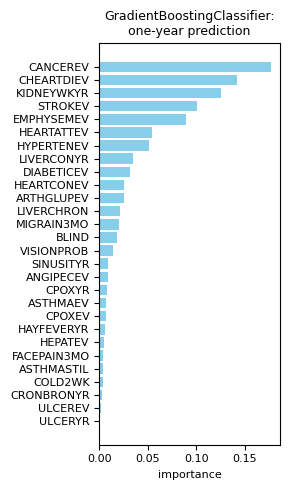

In [20]:
# plot feature importance
plt.figure(figsize=(3, 5))
plt.barh(feature_importance_df_1y['Feature'], feature_importance_df_1y['Importance'], color='skyblue')
plt.xlabel('importance', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title(f'{model_1y_name}:\none-year prediction', fontsize=9)
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.savefig(f'one_year_{model_1y_name}_no_age.jpg', format='jpg')
plt.show()

In [129]:
# P2

In [130]:
# we can use only samples tracked at least 3 years
df_3 = df[df['YEAR']<=2016] 

In [131]:
# define three-year mortalitty status
df_3 = df_3.copy()  # Ensure df_3 is a copy, not a slice
df_3.loc[:, 'MORTSTAT_3Y'] = np.where((df_3['MORTDODY'] - df_3['YEAR']) <= 3, 1, 0)

In [132]:
# split data into trainign and test set
df_3_train, df_3_test = train_test_split(df_3, test_size=0.2, random_state=21)

In [133]:
# select features and target
X_train_3y = df_3_train[illnesses1 + illnesses2 + illnesses3 + illnesses4 + illnesses5 + illnesses6 + illnesses7 + illnesses8 + illnesses9]
y_train_3y = df_3_train['MORTSTAT_3Y']

X_test_3y = df_3_test[illnesses1 + illnesses2 + illnesses3 + illnesses4 + illnesses5 + illnesses6 + illnesses7 + illnesses8 + illnesses9]
y_test_3y = df_3_test['MORTSTAT_3Y']

In [134]:
model_3y_name = 'GradientBoostingClassifier'
#model_3y = DecisionTreeClassifier(class_weight='balanced', random_state=42)
model_3y = GradientBoostingClassifier(n_estimators=100, learning_rate=0.2, random_state=10)
#model_3y = RandomForestClassifier(class_weight='balanced', n_estimators=1000, random_state=42)

# train
model_3y.fit(X_train_3y, y_train_3y)

GradientBoostingClassifier(learning_rate=0.2, random_state=10)

In [135]:
# get predicted probabilities
y_pred_proba_train_3y = model_3y.predict_proba(X_train_3y)
y_pred_proba_test_3y = model_3y.predict_proba(X_test_3y)

# compute Log Loss
logloss_train_3y = log_loss(y_train_3y, y_pred_proba_train_3y)
logloss_test_3y = log_loss(y_test_3y, y_pred_proba_test_3y)

print(f'Log Loss is: {logloss_train_3y:.4f}')
print(f'Log Loss os: {logloss_test_3y:.4f}')

Log Loss is: 0.1332
Log Loss os: 0.1338


In [136]:
# CV loss
log_loss_scorer = make_scorer(log_loss, response_method='predict_proba')
cv_scores_3y = cross_val_score(model_3y, df_3[illnesses1 + illnesses2 + illnesses3 + illnesses4 + illnesses5 + illnesses6 + illnesses7 + illnesses8 + illnesses9],
                            df_3['MORTSTAT_3Y'], cv=5, scoring=log_loss_scorer)

print(f"Cross-validation log-loss: {np.mean(cv_scores_3y)} ± {np.std(cv_scores_3y)}")

Cross-validation log-loss: 0.1345783306247763 ± 0.0005536542838466014


In [137]:
# get feature importances
importances_3y = model_3y.feature_importances_

# create a DataFrame for feature importance
feature_importance_df_3y = pd.DataFrame({
    'Feature': X_train_3y.columns,
    'Importance': importances_3y
})

# sort the DataFrame by importance
feature_importance_df_3y = feature_importance_df_3y.sort_values(by='Importance', ascending=False)

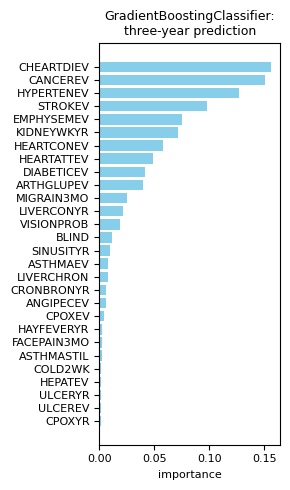

In [138]:
# plot feature importance
plt.figure(figsize=(3, 5))
plt.barh(feature_importance_df_3y['Feature'], feature_importance_df_3y['Importance'], color='skyblue')
plt.xlabel('importance', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title(f'{model_3y_name}:\nthree-year prediction', fontsize=9)
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.savefig(f'three_year_{model_3y_name}_no_age.jpg', format='jpg')
plt.show()

In [139]:
# P3 

In [23]:
# run Cox regression 
df_cox = df_train[illnesses1 + illnesses2 + illnesses3 +
            illnesses4 + illnesses5 + illnesses6 + 
            illnesses7 + illnesses8 + illnesses9 + ['TIMETOEVENT', 'MORTSTAT']]

cph = CoxPHFitter()
cph.fit(df_cox, duration_col='TIMETOEVENT', event_col='MORTSTAT')

# print summary
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 240089 total observations, 222346 right-censored observations>
             duration col = 'TIMETOEVENT'
                event col = 'MORTSTAT'
      baseline estimation = breslow
   number of observations = 240089
number of events observed = 17743
   partial log-likelihood = -201722.16
         time fit was run = 2025-02-22 09:30:50 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
CANCEREV     0.78      2.19      0.02            0.75            0.82                2.11                2.27
DIABETICEV   0.38      1.46      0.02            0.34            0.42                1.41                1.52
HEARTATTEV   0.39      1.48      0.03            0.34            0.45                1.40                1.57
CHEARTDIEV   0.43      1.53      0.03            0.38            0.48                1.46                1.61
STROKEV      0.61      1.84      0.02            0.56            0.66                1.75                1.93
HEARTCONEV   0.35      1.42      0.02            0.31            0.39                1.36                1.48
HYPERTENEV   0.72      2.06      0.02            0.69            0.76                1.99                2.14
ANGIPECEV   -0.16      0.85      0.03           -0.23           -0.10                0.80                0.91
EMPHYSEMEV   0.90      2.46      0.03            0.84            0.96                2.32                2.61
CRONBRONYR   0.15      1.16      0.03            0.09            0.21                1.09                1.23
ASTHMAEV    -0.27      0.76      0.04           -0.35           -0.19                0.70                0.82
ASTHMASTIL   0.04      1.04      0.05           -0.05            0.13                0.95                1.14
LIVERCHRON   0.32      1.37      0.06            0.20            0.43                1.23                1.54
LIVERCONYR   0.12      1.13      0.05            0.02            0.23                1.02                1.25
HEPATEV      0.10      1.10      0.04            0.02            0.17                1.02                1.18
KIDNEYWKYR   0.58      1.79      0.03            0.53            0.64                1.70                1.90
ULCEREV      0.12      1.13      0.03            0.07            0.17                1.07                1.18
ULCERYR     -0.06      0.94      0.05           -0.15            0.03                0.86                1.04
HAYFEVERYR  -0.11      0.89      0.03           -0.17           -0.05                0.84                0.95
SINUSITYR   -0.18      0.84      0.02           -0.22           -0.13                0.80                0.88
ARTHGLUPEV   0.50      1.65      0.02            0.47            0.53                1.59                1.70
MIGRAIN3MO  -0.58      0.56      0.03           -0.63           -0.53                0.53                0.59
FACEPAIN3MO -0.24      0.79      0.04           -0.31           -0.17                0.73                0.85
CPOXYR      -0.01      0.99      0.15           -0.30            0.27                0.74                1.31
CPOXEV      -0.17      0.84      0.02           -0.21           -0.13                0.81                0.87
COLD2WK     -0.15      0.86      0.03           -0.20           -0.10                0.82                0.91
VISIONPROB   0.28      1.33      0.02            0.24            0.33                1.28                1.38
BLIND        0.57      1.77      0.06            0.44            0.69                1.56                2.00

             cmp to      z      p  -log2(p)
covariate                                  
CANCEREV       0.00  43.06 <0.005       inf
DIABETICEV     0.00  20.14 <0.005    297.27
HEARTATTEV     0.00  14.16 <0.005    148.73
CHEARTDIEV     0.00  16.41 <0.005    198.59
STROKEV        0.00  24.43 <0.005    435.46
HEARTCONEV

In [24]:
print(f'APLL_is: {cph.score(df_train, scoring_method="log_likelihood"):.4f}')
print(f'APLL_os: {cph.score(df_test, scoring_method="log_likelihood"):.4f}')

APLL_is: -0.8402
APLL_os: -0.7561


In [25]:
print(f'APLL_is: {cph.score(df_train, scoring_method="concordance_index"):.3f}')
print(f'APLL_os: {cph.score(df_test, scoring_method="concordance_index"):.3f}')

APLL_is: 0.787
APLL_os: 0.782


In [155]:
# APLL CV
def cross_validate_cph_APLL(df, k):
    
    # intialize
    kf = KFold(n_splits=k, shuffle=True, random_state=20)
    # empty list for k-fold log-losses
    apll_list = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(df)):
        train_df, test_df = df.iloc[train_idx], df.iloc[test_idx]

        # fit Cox model
        cph = CoxPHFitter()
        cph.fit(train_df, duration_col='TIMETOEVENT', event_col='MORTSTAT')

        # compute survival probabilities for all test samples
        apll_avr = cph.score(df_train, scoring_method="log_likelihood")
        
        apll_list.append(apll_avr)

    return apll_list

list_apll = cross_validate_cph_APLL(df[illnesses1 + illnesses2 + illnesses3 +
                                      illnesses4 + illnesses5 + illnesses6 + 
                                      illnesses7 + illnesses8 + illnesses9 + ['TIMETOEVENT', 'MORTSTAT']], 5)
print(f'APLL CV: {np.mean(list_apll):.4f}')

APLL CV: -0.8402


In [30]:
# predict the survival function for each individual
survival_probs_train_cox = cph.predict_survival_function(df_train)
survival_probs_test_cox = cph.predict_survival_function(df_test)

# extract 1y survival probabilities
survival_prob_1y_train_cox = survival_probs_train_cox.iloc[1] 
survival_prob_1y_test_cox = survival_probs_test_cox.iloc[1] 
# extract 3y survival probabilities
survival_prob_3y_train_cox = survival_probs_train_cox.iloc[3] 
survival_prob_3y_test_cox = survival_probs_test_cox.iloc[3] 


# get 1-year event status based on TIMETOEVENT and MORTSTAT
status_1y_train_cox = np.where((df_train["MORTSTAT"] == 1) & (df_train["TIMETOEVENT"] <= 1), 0, 1)
status_1y_test_cox = np.where((df_test["MORTSTAT"] == 1) & (df_test["TIMETOEVENT"] <= 1), 0, 1)
# get 3-year event status based on TIMETOEVENT and MORTSTAT
status_3y_train_cox = np.where((df_train["MORTSTAT"] == 1) & (df_train["TIMETOEVENT"] <= 3), 0, 1)
status_3y_test_cox = np.where((df_test["MORTSTAT"] == 1) & (df_test["TIMETOEVENT"] <= 3), 0, 1)

In [31]:
print(f'log-loss 1y is: {log_loss(status_1y_train_cox, survival_prob_1y_train_cox):.4f}')
print(f'log-loss 1y os: {log_loss(status_1y_test_cox, survival_prob_1y_test_cox):.4f}')

log-loss 1y is: 0.0656
log-loss 1y os: 0.0660


In [32]:
print(f'log-loss 3y is: {log_loss(status_3y_train_cox, survival_prob_3y_train_cox):.4f}')
print(f'log-loss 3y os: {log_loss(status_3y_test_cox, survival_prob_3y_test_cox):.4f}')

log-loss 3y is: 0.1315
log-loss 3y os: 0.1330


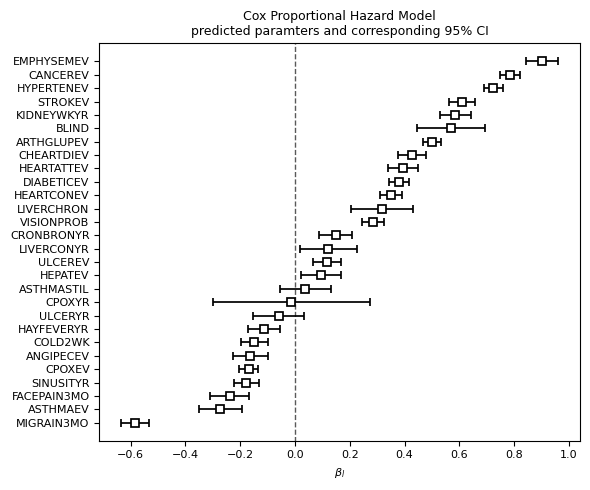

In [145]:
plt.subplots(figsize = (6, 5))
cph.plot()
plt.title(f'Cox Proportional Hazard Model\npredicted paramters and corresponding 95% CI', fontsize=9)
plt.xlabel(r'$\beta_l$', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig('coef_cox_dataset_encodings.png', format='png')
plt.show()

In [146]:
# CV for P3

In [43]:
def cross_validate_cph(df, k, i):
    
    # intialize
    kf = KFold(n_splits=k, shuffle=True, random_state=20)
    # empty list for k-fold log-losses
    losses = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(df)):
        train_df, test_df = df.iloc[train_idx], df.iloc[test_idx]

        # fit Cox model
        cph = CoxPHFitter()
        cph.fit(train_df, duration_col='TIMETOEVENT', event_col='MORTSTAT')

        # compute survival probabilities for all test samples
        probabilities = cph.predict_survival_function(test_df)

        # extract the survival probabilities at time point i
        probabilities_i = probabilities.iloc[i]  
        
        # extract event status after time i
        events_i = np.where((test_df["MORTSTAT"] == 1) & (test_df["TIMETOEVENT"] <= i), 0, 1)

        # store log-loss for current fold
        log_loss_i = log_loss(events_i, probabilities_i)
    
        losses.append(log_loss_i)

    return losses

In [44]:
surv_1_cox_cv = cross_validate_cph(df[illnesses1 + illnesses2 + illnesses3 +
                      illnesses4 + illnesses5 + illnesses6 + 
                      illnesses7 + illnesses8 + illnesses9 + ['TIMETOEVENT', 'MORTSTAT']], k=5, i=1)

print(f'Log-loss cv 1y cox: {np.mean(surv_1_cox_cv):.4f}')

Log-loss cv 1y cox: 0.0657


In [45]:
surv_3_cox_cv = cross_validate_cph(df[illnesses1 + illnesses2 + illnesses3 +
                      illnesses4 + illnesses5 + illnesses6 + 
                      illnesses7 + illnesses8 + illnesses9 + ['TIMETOEVENT', 'MORTSTAT']], k=5, i=3)

print(f'Log-loss cv 3y cox: {np.mean(surv_3_cox_cv):.4f}')

Log-loss cv 3y cox: 0.1318
